In [12]:
#Imports
import torch
import torch.nn as nn
import torch.cuda.amp as amp
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.functional import relu
import cv2 as cv
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import wandb
import io
import imageio
import matplotlib.pyplot as plt
from ipywidgets import widgets, HBox
from PIL import Image
import lpips

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [13]:
wandb.login()
wandb.init(
    # set the wandb project where this run will be logged
    project="convlstm_unet",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "Conv-LSTM",
    "dataset": "SHMU",
    "epochs": 20,
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [14]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # input: 512x288x3
        self.e11 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # output: 512x288x16
        self.e12 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 512x288x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 256x144x16

        # input: 256x144x16
        self.e21 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output: 256x144x32
        self.e22 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 256x144x32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x72x32

        # input: 128x72x32
        self.e31 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 128x72x64
        self.e32 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x72x64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x36x64

        # input: 64x36x64
        self.e41 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x36x128
        self.e42 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x36x128
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x18x128

        # input: 32x18x128
        self.e51 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x18x256
        self.e52 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x18x256



        # Decoder
        # input: 32x18x256
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x36x128
        self.d11 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x36x128
        self.d12 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x36x128
        
        # input: 64x36x128
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x72x64
        self.d21 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x72x64
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x72x64

        # input: 128x72x64
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # output: 256x144x32
        self.d31 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 256x144x32
        self.d32 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 256x144x32

        # input: 256x144x32
        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) # output: 512x288x16
        self.d41 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 512x288x16
        self.d42 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 512x288x16

        # Output layer
        self.outconv = nn.Conv2d(16, n_class, kernel_size=1) # output: 512x288x3 (n_class = 3) 
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xd11 = relu(self.d11(xu1))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xd21 = relu(self.d21(xu2))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xd31 = relu(self.d31(xu3))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xd41 = relu(self.d41(xu4))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [19]:
class SHMUDataset(Dataset):
    def __init__(self, data_frame, input_frames_length, target_frames_length, minutes):
        # Initialize the dataset with the given parameters
        self.data_frame = data_frame # DataFrame containing image paths
        self.input_frames_length = input_frames_length
        self.target_frames_length = target_frames_length
        self.minutes = minutes # Time difference between images in minutes 
        self.selected_paths = self.data_frame[::self.minutes // 5].iloc[:, 0].tolist() # Select every nth image based on the specified time difference

    def transform(self, image_path):
        # Load and transform an image
        img = cv.imread(image_path)
        # Apply morphological operations
        morph_operator = cv.MORPH_OPEN
        element = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
        morphed = cv.morphologyEx(src=img, op=morph_operator, kernel=element, iterations=2)
        # Crop and resize the image
        cropped = morphed[283:1147, 537:2087]
        resized = cv.resize(cropped, (512,288))
        # Convert the image to RGB and then to NumPy array
        image_rgb = cv.cvtColor(resized, cv.COLOR_BGR2RGB)
        image = np.array(image_rgb)
        return image

    def __len__(self):
        return len(self.selected_paths) 

    def __getitem__(self, idx):  
        np_input_frames = np.stack([self.transform(path) for path in self.selected_paths[idx:idx+self.input_frames_length]] , axis=0)
        # Convert to float, and normalize by dividing by 255 to scale pixel values to [0, 1]
        input_frames = torch.from_numpy(np_input_frames.transpose(0,3,1,2)).transpose(0,1).float() / 255.0
         # If there's only one target frame, remove the singleton dimension
        if self.input_frames_length == 1:
            input_frames = input_frames.squeeze(1)
        # Reshape input to match expected format (channels x height x width)
        else: input_frames = torch.reshape(input_frames, (-1, 288, 512))
        # Targets for encoder-decoder training are the input frames
        target_frames = input_frames
        return input_frames, target_frames


In [20]:
# Load Data as Numpy Array
data = pd.read_csv("dataset.csv")
print(data.shape)

# # Train, Test, Validation splits
train_data = SHMUDataset(data[:64000], minutes = 5, input_frames_length = 1, target_frames_length = 1) 
val_data = SHMUDataset(data[64000:72000], minutes = 5, input_frames_length = 1, target_frames_length = 1)      
test_data = SHMUDataset(data[72000:80000], minutes = 5, input_frames_length = 1, target_frames_length = 1)    

# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=32,num_workers=24,generator=torch.Generator(device=device))

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=32,num_workers=24,generator=torch.Generator(device=device))


(814492, 1)


In [17]:
model_unet = UNet(3).to(device)

optim = Adam(model_unet.parameters(), lr=1e-4)

loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

criterion = nn.MSELoss(reduction='mean')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/jupyter-bianka_szepesiova/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-bianka_szepesiova/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/jupyter-bianka_szepesiova/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
# Set `use_wandb` to True if you want to enable the use of Weights & Biases for experiment tracking and visualization.
use_wandb = True
# Initialize the GradScaler for automatic mixed precision (AMP) training
scaler = amp.GradScaler()
num_epochs = 20
for epoch in range(1, num_epochs+1):
    train_loss = 0
    model_unet.train()
    # Initialize a progress bar for the training loop
    loop = tqdm(train_loader)
    for batch_num, (input, target) in enumerate(loop, 1):
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = model_unet(input.to(device))
            output = output.to(device)
            target = target.to(device)
            # Compute the MSE loss
            mse_loss = criterion(output.flatten(), target.flatten())
            # Compute the perceptual loss
            perceptual_loss = loss_fn_vgg(output, target)
            # Combine the losses
            loss = mse_loss + perceptual_loss
            loss = loss.sum()
        
        # Scale the loss, perform backpropagation, and update the weights
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
        train_loss += loss.item()
        
    # Calculate the average training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    
    # Validation loop
    val_loss = 0
    model_unet.eval()
    with torch.no_grad():
        for input, target in val_loader:
            with torch.cuda.amp.autocast():
                output = model_unet(input.to(device))
                output = output.to(device)
                target = target.to(device)
                # Compute the MSE loss
                mse_loss = criterion(output.flatten(), target.flatten())
                # Compute the perceptual loss
                perceptual_loss = loss_fn_vgg(output, target)
                # Combine the losses
                loss = mse_loss + perceptual_loss
                loss = loss.sum()
            val_loss += loss.item()
            
    # Calculate the average validation loss and accuracy for the epoch
    val_loss /= len(val_loader)
    
    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))
    torch.cuda.empty_cache()
    # Update the progress bar description and postfix
    loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
    loop.set_postfix(loss=loss.item())
    if use_wandb: wandb.log({"val_loss": val_loss, "train_loss": train_loss})
if use_wandb: wandb.finish()

In [23]:
torch.save(model_unet.state_dict(), "path/to/model")
# model_unet.load_state_dict(torch.load("path/to/model"))
# model_unet.eval()

UNet(
  (e11): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(128, 256, kernel_size=(3, 3), st

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


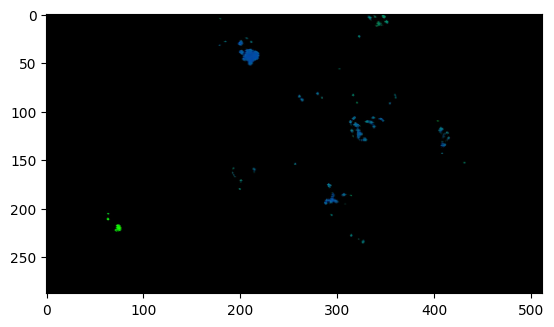

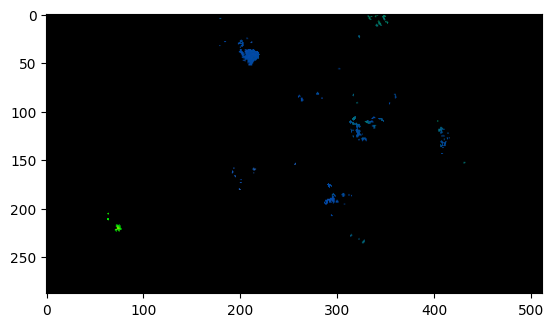

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


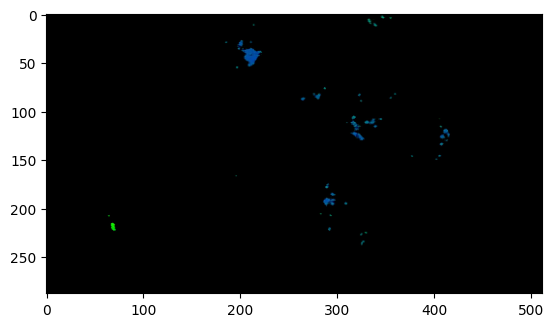

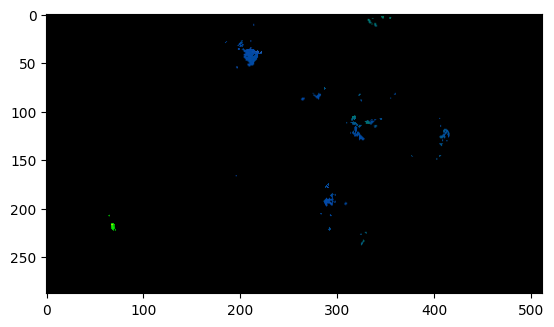

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


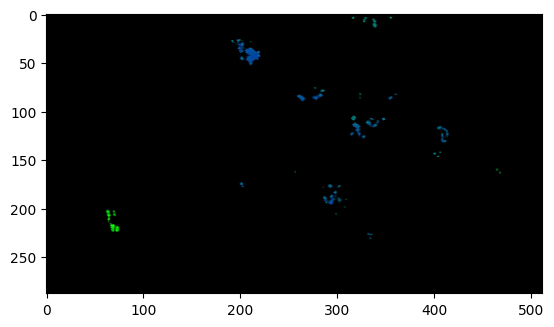

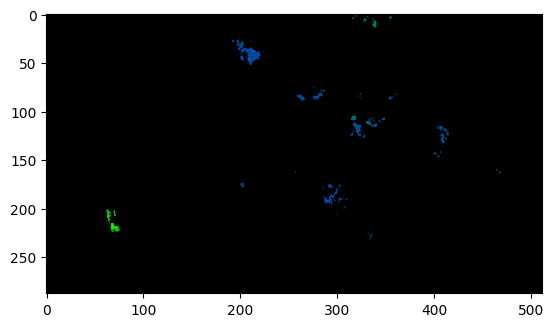

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


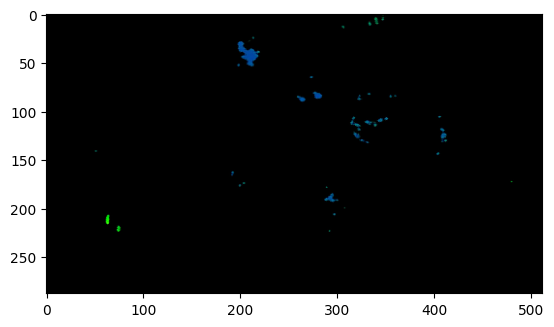

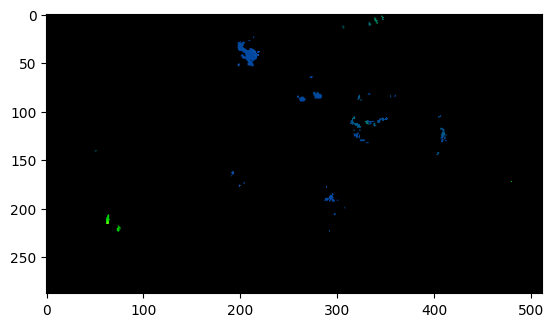

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


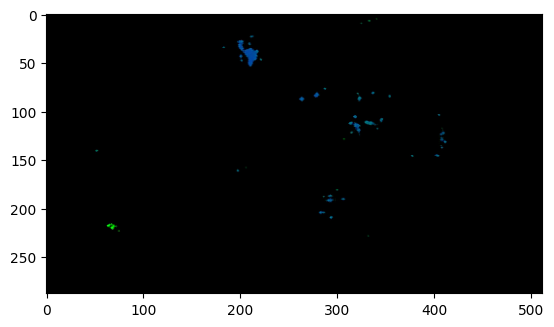

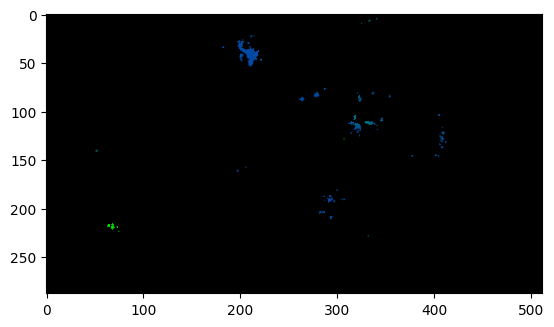

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


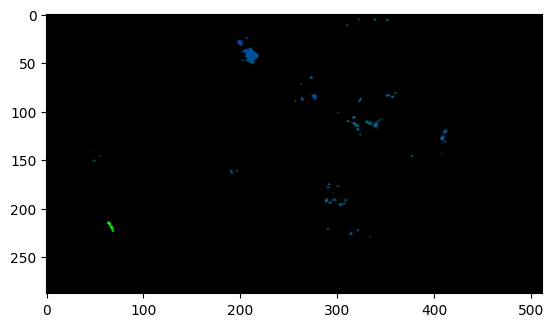

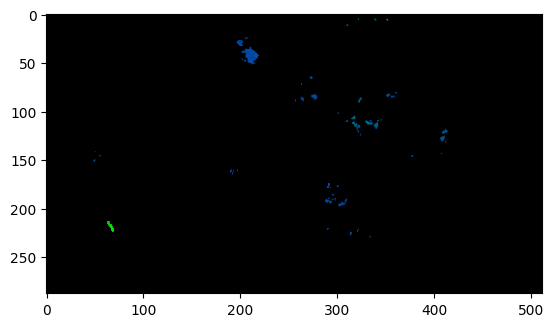

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


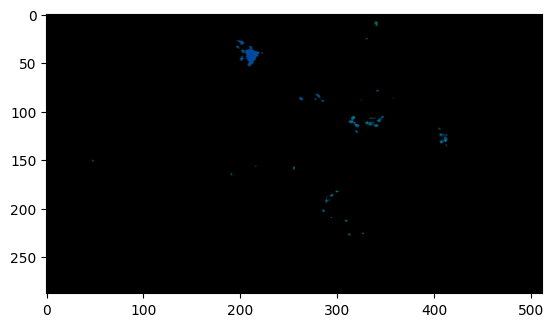

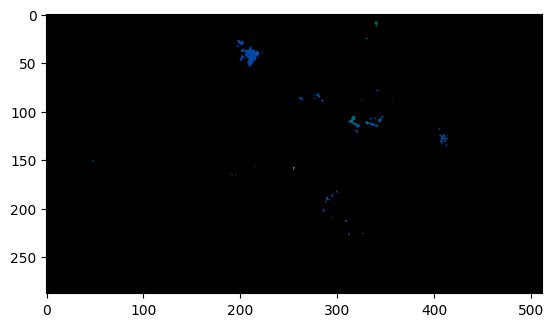

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


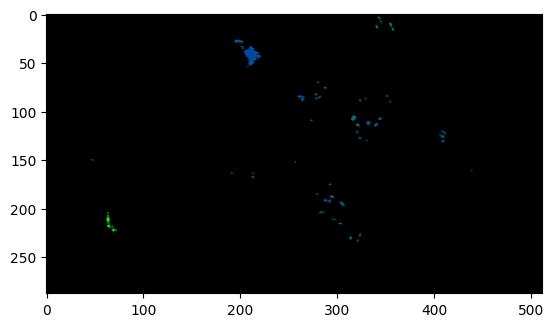

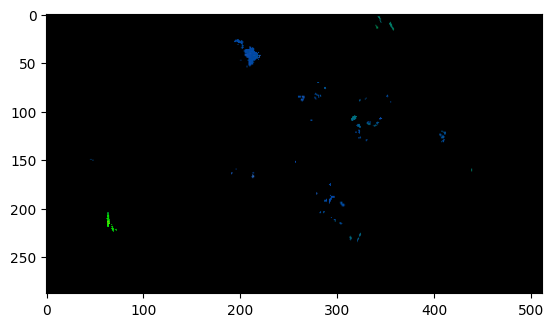

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


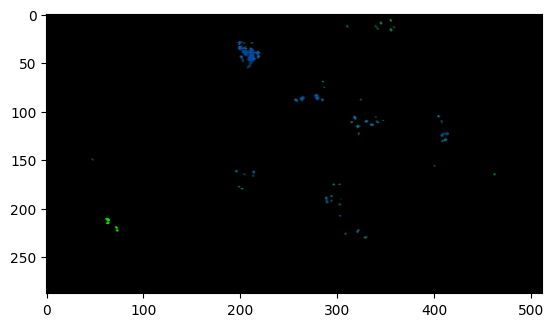

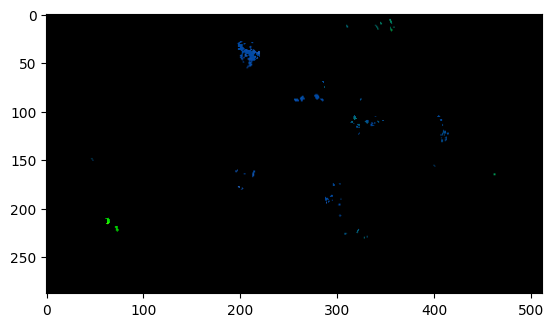

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


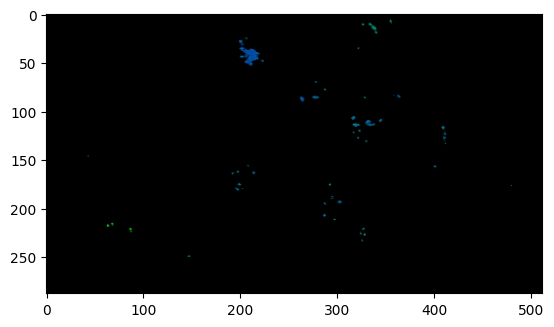

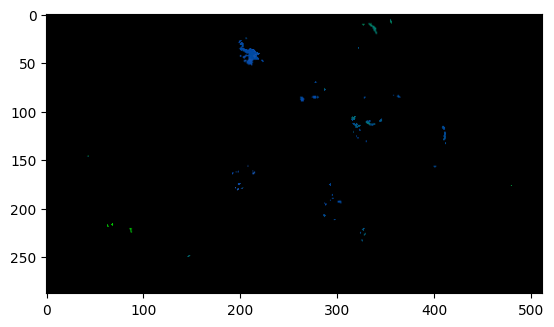

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


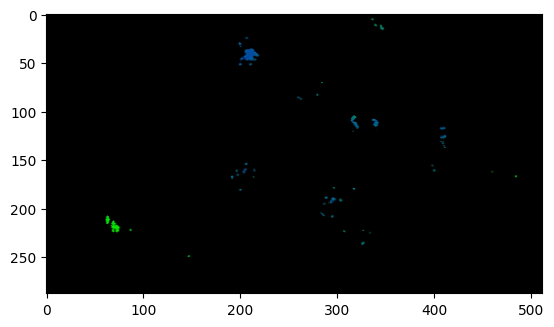

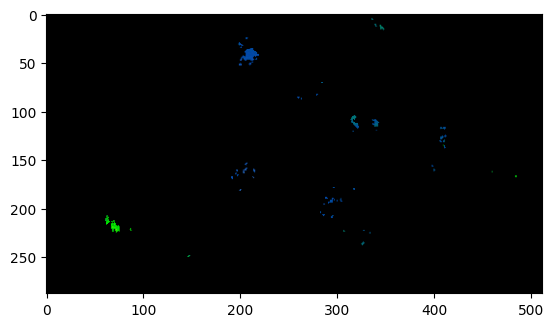

In [24]:
test_loader = DataLoader(test_data,shuffle=False, batch_size=1,num_workers=24,generator=torch.Generator(device=device))
i = 0
for batch,target in test_loader:
    output=(model_unet(batch.to(device)).detach().cpu())

    plt.imshow(output.transpose(1,2).transpose(2,3).squeeze(0))
    plt.show()
    plt.imshow(target.transpose(1,2).transpose(2,3).squeeze(0))
    plt.show()
    if i == 10:
        break
    i+=1